In [4]:
import torch
import openmm as mm
from openmm import app, unit
import numpy as np
import torch
import openmm as mm
from openmm import app, unit
import numpy as np

class EnergyCalculator:
    def __init__(self, pdb_file, forcefield_files=['amber99sb.xml', 'tip3p.xml'],
    
                 add_hydrogens=False, prefer_gpu=True):
        """
        Initializes the OpenMM system from a PDB file and force fields.
        """
        self.pdb = app.PDBFile(pdb_file)
        self.forcefield = app.ForceField(*forcefield_files)
       
        # Add missing hydrogens if needed
        if add_hydrogens:
            print("Adding hydrogens to the structure...")
            modeller = app.Modeller(self.pdb.topology, self.pdb.positions)
            modeller.addHydrogens(self.forcefield)
            self.topology = modeller.topology
            self.positions = modeller.positions
        else:
            self.topology = self.pdb.topology
            self.positions = self.pdb.positions

        self.system = self.forcefield.createSystem(self.topology, nonbondedMethod=app.NoCutoff)
        
        # We don't need a full-blown integrator for single-point energy
        self.integrator = mm.VerletIntegrator(1.0 * unit.femtoseconds)
        
        # Setup platform with proper error handling
        self.platform, properties = self._setup_platform(prefer_gpu)
            
        self.context = mm.Context(self.system, self.integrator, self.platform, properties)
        print(f"OpenMM context created on: {self.context.getPlatform().getName()}")
        
        # Print additional info for GPU platforms
        if self.platform.getName() in ['CUDA', 'OpenCL']:
            self._print_gpu_info()

    def _setup_platform(self, prefer_gpu=True):
        """Setup the best available platform."""
        
        if not prefer_gpu:
            platform = mm.Platform.getPlatformByName('CPU')
            return platform, {}
        
        # Try CUDA first with different configurations
        cuda_configs = [
            {'CudaPrecision': 'mixed'},
            {'CudaPrecision': 'single'},
            {'CudaPrecision': 'mixed', 'DeviceIndex': '0'},
            {'CudaPrecision': 'single', 'DeviceIndex': '0'},
        ]
        
        for config in cuda_configs:
            try:
                platform = mm.Platform.getPlatformByName('CUDA')
                
                # Test the configuration
                test_system = mm.System()
                test_system.addParticle(1.0)
                test_integrator = mm.VerletIntegrator(1.0 * unit.femtoseconds)
                test_context = mm.Context(test_system, test_integrator, platform, config)
                
                # If we get here, it works
                del test_context, test_integrator, test_system
                print(f"CUDA platform configured successfully with: {config}")
                return platform, config
                
            except Exception as e:
                print(f"CUDA config {config} failed: {e}")
                continue
        
        # Try OpenCL as fallback
        try:
            platform = mm.Platform.getPlatformByName('OpenCL')
            properties = {'OpenCLPrecision': 'mixed'}
            
            # Test OpenCL
            test_system = mm.System()
            test_system.addParticle(1.0)
            test_integrator = mm.VerletIntegrator(1.0 * unit.femtoseconds)
            test_context = mm.Context(test_system, test_integrator, platform, properties)
            del test_context, test_integrator, test_system
            
            print("OpenCL platform configured successfully")
            return platform, properties
            
        except Exception as e:
            print(f"OpenCL failed: {e}")
        
        # Fall back to CPU
        print("Falling back to CPU platform")
        platform = mm.Platform.getPlatformByName('CPU')
        return platform, {}
    
    def _print_gpu_info(self):
        """Print GPU information for debugging."""
        try:
            platform_name = self.context.getPlatform().getName()
            if platform_name == 'CUDA':
                # For CUDA, try to get device info
                try:
                    device_index = self.context.getPlatform().getPropertyValue(self.context, 'DeviceIndex')
                    precision = self.context.getPlatform().getPropertyValue(self.context, 'CudaPrecision')
                    print(f"CUDA Device Index: {device_index}")
                    print(f"CUDA Precision: {precision}")
                except:
                    print("CUDA device info not available")
            elif platform_name == 'OpenCL':
                try:
                    device_index = self.context.getPlatform().getPropertyValue(self.context, 'DeviceIndex')
                    precision = self.context.getPlatform().getPropertyValue(self.context, 'OpenCLPrecision')
                    print(f"OpenCL Device Index: {device_index}")
                    print(f"OpenCL Precision: {precision}")
                except:
                    print("OpenCL device info not available")
        except Exception as e:
            print(f"Could not get platform info: {e}")

    @torch.no_grad()
    def __call__(self, coords_tensor):
        """
        Calculates the potential energy for a given set of coordinates.
        
        Args:
            coords_tensor (torch.Tensor): A tensor of shape (num_atoms, 3).
                                          Assumes coordinates are in Angstroms.
        
        Returns:
            torch.Tensor: A scalar tensor containing the potential energy in kJ/mol.
        """
        # Convert torch tensor to OpenMM-compatible format (NumPy array with units)
        coords_numpy = coords_tensor.detach().cpu().numpy()
        positions = coords_numpy * unit.angstrom
        
        self.context.setPositions(positions)
        state = self.context.getState(getEnergy=True)
        energy = state.getPotentialEnergy().value_in_unit(unit.kilojoules_per_mole)
     

        
        return torch.tensor(energy, dtype=torch.float32)

In [5]:
# First, let's diagnose the issue
import torch
import openmm as mm
from openmm import app, unit

# Check your versions
print("PyTorch CUDA version:", torch.version.cuda)
print("PyTorch CUDA available:", torch.cuda.is_available())
print("OpenMM version:", mm.__version__)

# Check available platforms
print("\nAvailable OpenMM platforms:")
for i in range(mm.Platform.getNumPlatforms()):
    platform = mm.Platform.getPlatform(i)
    print(f"  {platform.getName()}")

# Check CUDA platform properties
try:
    cuda_platform = mm.Platform.getPlatformByName('CUDA')
    print(f"\nCUDA platform properties:")
    for j in range(cuda_platform.getNumProperties()):
        prop_name = cuda_platform.getPropertyName(j)
        default_value = cuda_platform.getPropertyDefaultValue(prop_name)
        print(f"  {prop_name}: {default_value}")
except Exception as e:
    print(f"CUDA platform error: {e}")

PyTorch CUDA version: 12.9
PyTorch CUDA available: True
OpenMM version: 8.3

Available OpenMM platforms:
  Reference
  CPU
  CUDA
  OpenCL

CUDA platform properties:
CUDA platform error: 'Platform' object has no attribute 'getNumProperties'


In [6]:
# Test with CUDA enabled
try:
    physics_critic = EnergyCalculator(
        pdb_file='../DATA/raw/protein_only.pdb',
        forcefield_files=['amber99sb.xml', 'tip3p.xml'],
        prefer_gpu=True
    )
    print("✅ CUDA setup successful!")
    
    # Test with dummy coordinates
    dummy_coords = torch.randn(physics_critic.system.getNumParticles(), 3) * 0.1
    energy = physics_critic(dummy_coords)
    print(f"Test energy calculation: {energy} kJ/mol")
    
except Exception as e:
    print(f"❌ CUDA setup failed: {e}")
    
    # Fallback to CPU
    physics_critic = EnergyCalculator(
        pdb_file='../DATA/raw/protein_only.pdb',
        forcefield_files=['amber99sb.xml', 'tip3p.xml'],
        prefer_gpu=False
    )
    print("✅ CPU fallback successful!")

CUDA config {'CudaPrecision': 'mixed'} failed: Error loading CUDA module: CUDA_ERROR_UNSUPPORTED_PTX_VERSION (222)
CUDA config {'CudaPrecision': 'single'} failed: Error loading CUDA module: CUDA_ERROR_UNSUPPORTED_PTX_VERSION (222)
CUDA config {'CudaPrecision': 'mixed', 'DeviceIndex': '0'} failed: Error loading CUDA module: CUDA_ERROR_UNSUPPORTED_PTX_VERSION (222)
CUDA config {'CudaPrecision': 'single', 'DeviceIndex': '0'} failed: Error loading CUDA module: CUDA_ERROR_UNSUPPORTED_PTX_VERSION (222)
OpenCL platform configured successfully
OpenMM context created on: OpenCL
OpenCL Device Index: 0
OpenCL Precision: mixed
✅ CUDA setup successful!
Test energy calculation: 1.324416558336308e+31 kJ/mol


In [7]:
import sys
sys.path.append("LIBS")
from LIBS.utils import *

dataset = get_dataset(scale_pos = False)

/home/clod/anaconda3/envs/pytorch/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Loading dataset ...

No root directory provided, using default path ...
Successfully loaded processed data from /home/clod/Desktop/THESIS_2/FULL_ATOM/DATA/processed/data_MD_protein.pt
Positions shape: torch.Size([20032, 52, 3])
Including atom features: performing one hot encoding ...
Scaling features ...
not aligning the frames ...
Dataset created with 20032 graphs.
Number of graphs in the dataset: 20032
Number of features in the dataset: 6
Number of edges in the dataset: 102
Number of nodes in the dataset: 52
Number of features in the dataset: torch.Size([52, 6])



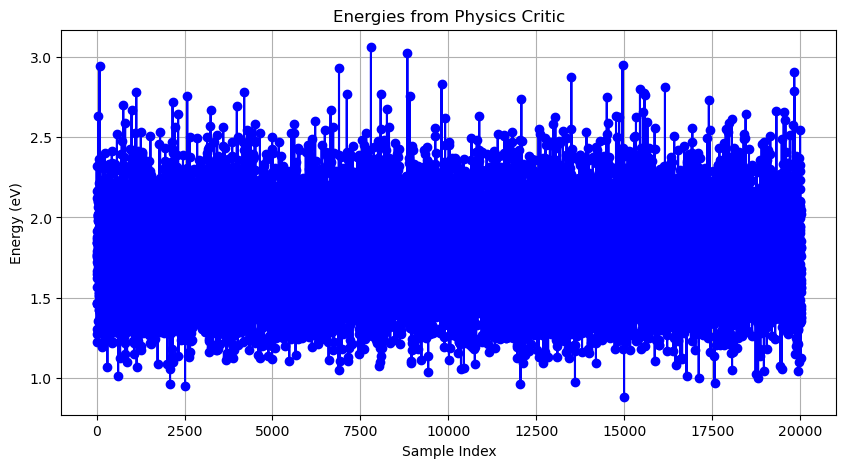

In [8]:
energies = [physics_critic(coords) for coords in dataset.pos.view(dataset.num_graphs, -1, 3)]
energies = torch.stack(energies)

# convert energies from kJ/mol to eV
energies = energies / 96.485

# plot energies
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 5))
plt.plot(energies.numpy(), marker='o', linestyle='-', color='b')
plt.title('Energies from Physics Critic')
plt.xlabel('Sample Index')
plt.ylabel('Energy (eV)')
plt.grid()
plt.show()

## Lennard-Jones approximation
Idea: use a differentiable approach to make the model able to backpropagate errors during training, then use exact force field for fine-tuning

In [9]:
not_scaled_dataset = get_dataset(scale_pos = False, scale_features= False, verbose=True)
scaled_dataset = get_dataset(scale_pos = False, scale_features= True, verbose=True)
print(not_scaled_dataset[0].x[0])
print(scaled_dataset[0].x[0])


Loading dataset ...

No root directory provided, using default path ...
Successfully loaded processed data from /home/clod/Desktop/THESIS_2/FULL_ATOM/DATA/processed/data_MD_protein.pt
Positions shape: torch.Size([20032, 52, 3])
Including atom features: performing one hot encoding ...
not aligning the frames ...
Dataset created with 20032 graphs.
Number of graphs in the dataset: 20032
Number of features in the dataset: 6
Number of edges in the dataset: 102
Number of nodes in the dataset: 52
Number of features in the dataset: torch.Size([52, 6])

Loading dataset ...

No root directory provided, using default path ...
Successfully loaded processed data from /home/clod/Desktop/THESIS_2/FULL_ATOM/DATA/processed/data_MD_protein.pt
Positions shape: torch.Size([20032, 52, 3])
Including atom features: performing one hot encoding ...
Scaling features ...
not aligning the frames ...
Dataset created with 20032 graphs.
Number of graphs in the dataset: 20032
Number of features in the dataset: 6
Numb

In [10]:
class LennardJones_calculator:
      def __init__(self, pdb_file):
        """
        Initialize the LennardJones_calculator.

        """
        self.pdb = app.PDBFile(pdb_file)

        
      

In [11]:
import MDAnalysis as mda
pdb_file='../DATA/raw/protein_only.pdb'

u = mda.Universe(pdb_file)

atoms = u.atoms

print(atoms.names)

# Define reference bond lengths for different atom type pairs
    # Values in Angstroms, based on common chemistry
bond_params = {
    (0, 0): {'length': 1.54, 'k': 300.0},  # C-C
    (0, 1): {'length': 1.09, 'k': 340.0},  # C-H
    (0, 2): {'length': 1.43, 'k': 320.0},  # C-N
    (0, 3): {'length': 1.43, 'k': 350.0},  # C-O
    (1, 1): {'length': 0.74, 'k': 300.0},  # H-H
    (1, 2): {'length': 1.01, 'k': 330.0},  # H-N
    (1, 3): {'length': 0.96, 'k': 380.0},  # H-O
    (2, 2): {'length': 1.47, 'k': 300.0},  # N-N
    (2, 3): {'length': 1.44, 'k': 320.0},  # N-O
    (3, 3): {'length': 1.48, 'k': 300.0},  # O-O
}




['CH3' 'HH31' 'HH32' 'HH33' 'C' 'O' 'N' 'H' 'CA' 'HA' 'CB' 'HB1' 'HB2'
 'HB3' 'C' 'O' 'N' 'H' 'CA' 'HA' 'CB' 'HB1' 'HB2' 'HB3' 'C' 'O' 'N' 'H'
 'CA' 'HA' 'CB' 'HB1' 'HB2' 'HB3' 'C' 'O' 'N' 'H' 'CA' 'HA' 'CB' 'HB1'
 'HB2' 'HB3' 'C' 'O' 'N' 'H' 'CH3' 'HH31' 'HH32' 'HH33']


In [12]:
from openmm.app import *
from openmm import unit
import openmm
import numpy as np

# Load PDB and force field
pdb_file='../DATA/raw/protein_only.pdb'

pdb = PDBFile(pdb_file)
forcefield = ForceField("amber99sb.xml")

# Modeller prepares hydrogens
modeller = Modeller(pdb.topology, pdb.positions)
modeller.addHydrogens(forcefield)

# Build the system with force field
system = forcefield.createSystem(modeller.topology, nonbondedMethod=NoCutoff)

# Extract atom types and LJ parameters from NonbondedForce
nbforce = None
for force in system.getForces():
    if isinstance(force, openmm.NonbondedForce):
        nbforce = force
        break

assert nbforce is not None, "No NonbondedForce found"

lj_data = []

for i, atom in enumerate(modeller.topology.atoms()):
    charge, sigma, epsilon = nbforce.getParticleParameters(i)
    lj_data.append({
        "index": i,
        "name": atom.name,
        "element": atom.element.symbol,
        "residue": atom.residue.name,
        "sigma": sigma.value_in_unit(unit.nanometers),
        "epsilon": epsilon.value_in_unit(unit.kilojoules_per_mole)
    })

# Print or export LJ data
for entry in lj_data:
    print(f"{entry['index']:>3} {entry['name']:>4} {entry['residue']:>3} | "
          f"σ = {entry['sigma']:.3f} nm | ϵ = {entry['epsilon']:.4f} kJ/mol")


  0  CH3 ACE | σ = 0.340 nm | ϵ = 0.4577 kJ/mol
  1   H1 ACE | σ = 0.265 nm | ϵ = 0.0657 kJ/mol
  2   H2 ACE | σ = 0.265 nm | ϵ = 0.0657 kJ/mol
  3   H3 ACE | σ = 0.265 nm | ϵ = 0.0657 kJ/mol
  4    C ACE | σ = 0.340 nm | ϵ = 0.3598 kJ/mol
  5    O ACE | σ = 0.296 nm | ϵ = 0.8786 kJ/mol
  6    N ALA | σ = 0.325 nm | ϵ = 0.7113 kJ/mol
  7    H ALA | σ = 0.107 nm | ϵ = 0.0657 kJ/mol
  8   CA ALA | σ = 0.340 nm | ϵ = 0.4577 kJ/mol
  9   HA ALA | σ = 0.247 nm | ϵ = 0.0657 kJ/mol
 10   CB ALA | σ = 0.340 nm | ϵ = 0.4577 kJ/mol
 11  HB1 ALA | σ = 0.265 nm | ϵ = 0.0657 kJ/mol
 12  HB2 ALA | σ = 0.265 nm | ϵ = 0.0657 kJ/mol
 13  HB3 ALA | σ = 0.265 nm | ϵ = 0.0657 kJ/mol
 14    C ALA | σ = 0.340 nm | ϵ = 0.3598 kJ/mol
 15    O ALA | σ = 0.296 nm | ϵ = 0.8786 kJ/mol
 16    N ALA | σ = 0.325 nm | ϵ = 0.7113 kJ/mol
 17    H ALA | σ = 0.107 nm | ϵ = 0.0657 kJ/mol
 18   CA ALA | σ = 0.340 nm | ϵ = 0.4577 kJ/mol
 19   HA ALA | σ = 0.247 nm | ϵ = 0.0657 kJ/mol
 20   CB ALA | σ = 0.340 nm | ϵ = 0.4577

### Lorentz–Berthelot rules (default in AMBER and OpenMM)

$ σ_{ij}= \frac{σ_i+σ_j}{2} $ 

$ ϵ_{ij}=\sqrt{ϵ_i⋅ϵ_j} $

​

In [13]:
edg_ind = dataset[0].edge_index[:,0]

sigma = (lj_data[edg_ind[0]]['sigma'] + lj_data[edg_ind[1]]['sigma']) / 2
epsilon = np.sqrt(lj_data[edg_ind[0]]['epsilon'] * lj_data[edg_ind[1]]['epsilon'])

print(f"Sigma: {sigma}, Epsilon: {epsilon}")


Sigma: 0.3024601148085, Epsilon: 0.1734004271865557


In [14]:
edge_indexes = dataset[0].edge_index
edge_index_single = edge_indexes[:, edge_indexes[0] <= edge_indexes[1]]
print(edge_index_single)

n_atoms = len(edge_index_single[0]) + 1  # n_atoms - 1 bonds

sender, receiver = edge_index_single

def get_sigma(s,r, lj_dict):
    return 1/2*(lj_dict[s]['sigma'] + lj_dict[r]['sigma'])

def get_epsilon(s,r,lj_dict):
    return np.sqrt(lj_dict[s]['epsilon']*lj_dict[r]['epsilon'])

lj_param = []


for s,r in zip(sender,receiver):
    sigma = get_sigma(s,r,lj_data)
    epsilon = get_epsilon(s,r,lj_data)
    lj_param.append({ 
        "bond_indexes": [s.item(),r.item()],
        "sigma": sigma,
        "epsilon": epsilon
    })

lj_param

# NOTE THAT THIS IS AN EXAMPLE OF HOW TO WORK, I WILL USE LJ POTENTIAL ONLY FOR NONBONDED INTERACTIONS




tensor([[ 0,  0,  0,  0,  4,  4,  6,  6,  8,  8,  8, 10, 10, 10, 14, 14, 16, 16,
         18, 18, 18, 20, 20, 20, 24, 24, 26, 26, 28, 28, 28, 30, 30, 30, 34, 34,
         36, 36, 38, 38, 38, 40, 40, 40, 44, 44, 46, 46, 48, 48, 48],
        [ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 14, 11, 12, 13, 15, 16, 17, 18,
         19, 20, 24, 21, 22, 23, 25, 26, 27, 28, 29, 30, 34, 31, 32, 33, 35, 36,
         37, 38, 39, 40, 44, 41, 42, 43, 45, 46, 47, 48, 49, 50, 51]])


[{'bond_indexes': [0, 1],
  'sigma': 0.3024601148085,
  'epsilon': 0.1734004271865557},
 {'bond_indexes': [0, 2],
  'sigma': 0.3024601148085,
  'epsilon': 0.1734004271865557},
 {'bond_indexes': [0, 3],
  'sigma': 0.3024601148085,
  'epsilon': 0.1734004271865557},
 {'bond_indexes': [0, 4],
  'sigma': 0.339966950842,
  'epsilon': 0.4058350595875127},
 {'bond_indexes': [4, 5],
  'sigma': 0.3179795704785,
  'epsilon': 0.5622772975676681},
 {'bond_indexes': [4, 6],
  'sigma': 0.33248340161,
  'epsilon': 0.5059007953344212},
 {'bond_indexes': [6, 7],
  'sigma': 0.2159538492775,
  'epsilon': 0.21615533688530572},
 {'bond_indexes': [6, 8],
  'sigma': 0.33248340161,
  'epsilon': 0.5705908428006885},
 {'bond_indexes': [8, 9],
  'sigma': 0.293551127627,
  'epsilon': 0.1734004271865557},
 {'bond_indexes': [8, 10], 'sigma': 0.339966950842, 'epsilon': 0.4577296},
 {'bond_indexes': [8, 14],
  'sigma': 0.339966950842,
  'epsilon': 0.4058350595875127},
 {'bond_indexes': [10, 11],
  'sigma': 0.302460114

In [15]:
# extract the parameters for the harmonic potential over bonded interactions
from openmm import HarmonicBondForce

# Get HarmonicBondForce object
for force in system.getForces():
    if isinstance(force, HarmonicBondForce):
        bond_force = force
        break

# Extract bond parameters
bonds = []
k_list = []
r0_list = []

for i in range(bond_force.getNumBonds()):
    p1, p2, length, k = bond_force.getBondParameters(i)
    bonds.append((p1, p2))
    r0_list.append(length.value_in_unit_system(unit.md_unit_system))
    k_list.append(k.value_in_unit_system(unit.md_unit_system))


print("Bond Parameters:")   
for i, (p1, p2) in enumerate(bonds):
    print(f"Bond {i}: Atoms {p1} - {p2}, Length = {r0_list[i]:.3f} nm, k = {k_list[i]:.3f} kJ/mol/nm^2")

Bond Parameters:
Bond 0: Atoms 4 - 0, Length = 0.152 nm, k = 265265.600 kJ/mol/nm^2
Bond 1: Atoms 4 - 5, Length = 0.123 nm, k = 476976.000 kJ/mol/nm^2
Bond 2: Atoms 0 - 1, Length = 0.109 nm, k = 284512.000 kJ/mol/nm^2
Bond 3: Atoms 0 - 2, Length = 0.109 nm, k = 284512.000 kJ/mol/nm^2
Bond 4: Atoms 0 - 3, Length = 0.109 nm, k = 284512.000 kJ/mol/nm^2
Bond 5: Atoms 4 - 6, Length = 0.134 nm, k = 410032.000 kJ/mol/nm^2
Bond 6: Atoms 14 - 8, Length = 0.152 nm, k = 265265.600 kJ/mol/nm^2
Bond 7: Atoms 14 - 15, Length = 0.123 nm, k = 476976.000 kJ/mol/nm^2
Bond 8: Atoms 8 - 10, Length = 0.153 nm, k = 259408.000 kJ/mol/nm^2
Bond 9: Atoms 8 - 9, Length = 0.109 nm, k = 284512.000 kJ/mol/nm^2
Bond 10: Atoms 8 - 6, Length = 0.145 nm, k = 282001.600 kJ/mol/nm^2
Bond 11: Atoms 10 - 11, Length = 0.109 nm, k = 284512.000 kJ/mol/nm^2
Bond 12: Atoms 10 - 12, Length = 0.109 nm, k = 284512.000 kJ/mol/nm^2
Bond 13: Atoms 10 - 13, Length = 0.109 nm, k = 284512.000 kJ/mol/nm^2
Bond 14: Atoms 7 - 6, Length = 

In [16]:
def harmonic_bond_energy(r, r0, k):
    """
    Calculate the harmonic bond energy.
    
    Args:
        r (float): Current bond length.
        r0 (float): Equilibrium bond length.
        k (float): Force constant.
        
    Returns:
        float: Harmonic bond energy.
    """
    return 0.5 * k * (r - r0) ** 2

# test on the first bond


bond_index = 0
p1, p2 = bonds[bond_index]
r0 = r0_list[bond_index]
k = k_list[bond_index]
r_current = np.linalg.norm(not_scaled_dataset[0].pos[p1] - not_scaled_dataset[0].pos[p2])/10
#REMEMBER TO DIVIDE BY 10 TO CONVERT FROM ANGSTROM TO NM
print(f"Current bond length for bond {bond_index} (atoms {p1}-{p2}): {r_current:.3f} nm")
energy = harmonic_bond_energy(r_current, r0, k)
print(f"Harmonic bond energy for bond {bond_index} (atoms {p1}-{p2}): {energy:.3f} kJ/mol")
print()

for data in not_scaled_dataset[0:20]:

    energy= 0
    for i, (p1, p2) in enumerate(bonds):
        r_current = np.linalg.norm(data.pos[p1] - data.pos[p2])/10
        energy += harmonic_bond_energy(r_current, r0_list[i], k_list[i])

    print(f"Harmonic bond energy for all bonds: {energy:.3f} kJ/mol")


Current bond length for bond 0 (atoms 4-0): 0.152 nm
Harmonic bond energy for bond 0 (atoms 4-0): 0.002 kJ/mol

Harmonic bond energy for all bonds: 1.393 kJ/mol
Harmonic bond energy for all bonds: 62.082 kJ/mol
Harmonic bond energy for all bonds: 47.595 kJ/mol
Harmonic bond energy for all bonds: 23.749 kJ/mol
Harmonic bond energy for all bonds: 32.060 kJ/mol
Harmonic bond energy for all bonds: 60.379 kJ/mol
Harmonic bond energy for all bonds: 45.992 kJ/mol
Harmonic bond energy for all bonds: 33.703 kJ/mol
Harmonic bond energy for all bonds: 42.140 kJ/mol
Harmonic bond energy for all bonds: 24.961 kJ/mol
Harmonic bond energy for all bonds: 28.727 kJ/mol
Harmonic bond energy for all bonds: 43.015 kJ/mol
Harmonic bond energy for all bonds: 38.945 kJ/mol
Harmonic bond energy for all bonds: 43.859 kJ/mol
Harmonic bond energy for all bonds: 41.727 kJ/mol
Harmonic bond energy for all bonds: 47.632 kJ/mol
Harmonic bond energy for all bonds: 29.413 kJ/mol
Harmonic bond energy for all bonds: 34.

In [17]:
def lj_energy_vectorized(coords, sigma, epsilon, excluded_pairs=None, cutoff=10.0):
    """
    Vectorized Lennard-Jones energy computation.

    Args:
        coords: [N, 3] positions in Å (requires_grad=True)
        sigma: [N] tensor of per-atom σ (Å)
        epsilon: [N] tensor of per-atom ε (kJ/mol)
        excluded_pairs: set of (i, j) tuples to exclude
        cutoff: LJ cutoff distance in Å

    Returns:
        Scalar LJ energy
    """
    N = coords.shape[0]
    
    # Create distance matrix [N, N]
    rij = torch.cdist(coords, coords, p=2)  # pairwise distances

    # Avoid division by zero (diag)
    diag_mask = torch.eye(N, dtype=torch.bool, device=coords.device)
    rij[diag_mask] = float('inf')

    # Compute σ_ij and ε_ij using Lorentz-Berthelot combining rules
    sigma_i = sigma.unsqueeze(0)  # [1, N]
    sigma_j = sigma.unsqueeze(1)  # [N, 1]
    sigma_ij = 0.5 * (sigma_i + sigma_j)  # [N, N]

    epsilon_i = epsilon.unsqueeze(0)
    epsilon_j = epsilon.unsqueeze(1)
    epsilon_ij = torch.sqrt(epsilon_i * epsilon_j)

    # Compute LJ terms
    sr6 = (sigma_ij / rij) ** 6
    sr12 = sr6 ** 2
    E = 4 * epsilon_ij * (sr12 - sr6)

    # Mask excluded pairs
    if excluded_pairs is not None:
        mask = torch.ones((N, N), dtype=torch.bool, device=coords.device)
        for i, j in excluded_pairs:
            mask[i, j] = False
            mask[j, i] = False
        E = E * mask

    # Apply cutoff
    if cutoff is not None:
        E = E * (rij < cutoff)

    # Sum over i < j only
    energy = torch.triu(E, diagonal=1).sum()

    return energy

In [18]:
sigmas = torch.tensor([lj_data[i]['sigma'] for i in range(len(lj_data))])
epsilons = torch.tensor([lj_data[i]['epsilon'] for i in range(len(lj_data))])


for data in not_scaled_dataset[0:20]:
    coords = torch.rand_like(data.pos.view(-1, 3))
    non_bonded_energy = lj_energy_vectorized(
        coords=coords,
        sigma=sigmas,
        epsilon=epsilons,
        excluded_pairs=None, #set(bonds),
        cutoff=10.0  # 10 Å cutoff
    )
    print(f"Non-bonded Lennard-Jones energy: {non_bonded_energy:.3f} kJ/mol")


Non-bonded Lennard-Jones energy: 12501796864.000 kJ/mol
Non-bonded Lennard-Jones energy: 19322510.000 kJ/mol
Non-bonded Lennard-Jones energy: 65753684.000 kJ/mol
Non-bonded Lennard-Jones energy: 17075612391942651904.000 kJ/mol
Non-bonded Lennard-Jones energy: 1581420416.000 kJ/mol
Non-bonded Lennard-Jones energy: 672941408256.000 kJ/mol
Non-bonded Lennard-Jones energy: 9668964384768.000 kJ/mol
Non-bonded Lennard-Jones energy: 1248060416.000 kJ/mol
Non-bonded Lennard-Jones energy: 4487789568.000 kJ/mol
Non-bonded Lennard-Jones energy: 487662272.000 kJ/mol
Non-bonded Lennard-Jones energy: 34101848.000 kJ/mol
Non-bonded Lennard-Jones energy: 32972056576.000 kJ/mol
Non-bonded Lennard-Jones energy: 34814119936.000 kJ/mol
Non-bonded Lennard-Jones energy: 5743086.500 kJ/mol
Non-bonded Lennard-Jones energy: 12242962.000 kJ/mol
Non-bonded Lennard-Jones energy: 1698499968.000 kJ/mol
Non-bonded Lennard-Jones energy: 16165445632.000 kJ/mol
Non-bonded Lennard-Jones energy: 491255168.000 kJ/mol
Non-

In [23]:
from openmm import HarmonicAngleForce, unit

# Find the HarmonicAngleForce in your system
for force in system.getForces():
    if isinstance(force, HarmonicAngleForce):
        angle_force = force
        break

# Extract indices and parameters
angle_indices = []
angle_params = []

for i in range(angle_force.getNumAngles()):
    a1, a2, a3, theta0, k = angle_force.getAngleParameters(i)
    angle_indices.append([a1, a2, a3])
    angle_params.append((
        theta0.value_in_unit(unit.radian),  # equilibrium angle
        k.value_in_unit(unit.kilojoule_per_mole / unit.radian**2)  # force constant
    ))


angle_indices = torch.tensor(angle_indices, dtype=torch.long)
angle_params = torch.tensor(angle_params, dtype=torch.float32)

angle_params

tensor([[  2.1014, 669.4400],
        [  2.0351, 585.7600],
        [  1.9111, 292.8800],
        [  1.9111, 292.8800],
        [  1.9111, 418.4000],
        [  1.9111, 292.8800],
        [  1.9111, 418.4000],
        [  1.9111, 418.4000],
        [  2.0944, 418.4000],
        [  2.1276, 418.4000],
        [  2.1450, 669.4400],
        [  1.9111, 418.4000],
        [  1.9146, 669.4400],
        [  1.9216, 527.1840],
        [  2.0602, 418.4000],
        [  1.9111, 418.4000],
        [  1.9111, 418.4000],
        [  1.9111, 418.4000],
        [  2.1014, 669.4400],
        [  2.0351, 585.7600],
        [  1.9111, 418.4000],
        [  1.9111, 418.4000],
        [  1.9391, 527.1840],
        [  1.9111, 292.8800],
        [  1.9111, 292.8800],
        [  1.9111, 292.8800],
        [  2.0944, 418.4000],
        [  2.1276, 418.4000],
        [  2.1450, 669.4400],
        [  1.9111, 418.4000],
        [  1.9146, 669.4400],
        [  1.9216, 527.1840],
        [  2.0602, 418.4000],
        [ 

In [24]:
import torch

def angle_energy(coords, angle_indices, angle_params):
    """
    Computes harmonic angle energy.

    Args:
        coords: [N, 3] tensor of atomic positions (Å), requires_grad=True
        angle_indices: [M, 3] LongTensor of indices (A, B, C)
        angle_params: list of tuples [(theta0_rad, k_theta), ...] for each angle

    Returns:
        Scalar energy (kJ/mol)
    """
    idx_A = angle_indices[:, 0]
    idx_B = angle_indices[:, 1]
    idx_C = angle_indices[:, 2]

    A = coords[idx_A]  # [M, 3]
    B = coords[idx_B]
    C = coords[idx_C]

    # Vectors BA and BC
    BA = A - B
    BC = C - B

    # Normalize
    BA_norm = torch.nn.functional.normalize(BA, dim=1)
    BC_norm = torch.nn.functional.normalize(BC, dim=1)

    # Cosine of angle
    cos_theta = (BA_norm * BC_norm).sum(dim=1).clamp(-1.0, 1.0)
    theta = torch.acos(cos_theta)  # [M]

    # Parameters
    theta0 = torch.tensor([p[0] for p in angle_params], device=coords.device)
    k_theta = torch.tensor([p[1] for p in angle_params], device=coords.device)

    # Harmonic energy
    energy = 0.5 * k_theta * (theta - theta0) ** 2
    return energy.sum()


In [28]:
# Example usage
for i in range(20):
    # print(f"Angle indices for dataset {i}: {angle_indices[i]}")
    # print(f"Angle parameters for dataset {i}: {angle_params[i]}")
    coords = not_scaled_dataset[i].pos  # Random coordinates
    energy = angle_energy(coords, angle_indices, angle_params)

    print(f"Harmonic angle energy: {energy.item()} kJ/mol")


Harmonic angle energy: 99.47184753417969 kJ/mol
Harmonic angle energy: 117.1083755493164 kJ/mol
Harmonic angle energy: 87.04727172851562 kJ/mol
Harmonic angle energy: 90.0300521850586 kJ/mol
Harmonic angle energy: 106.15562438964844 kJ/mol
Harmonic angle energy: 87.70137786865234 kJ/mol
Harmonic angle energy: 92.94232177734375 kJ/mol
Harmonic angle energy: 83.69042205810547 kJ/mol
Harmonic angle energy: 91.54510498046875 kJ/mol
Harmonic angle energy: 93.04998016357422 kJ/mol
Harmonic angle energy: 110.65350341796875 kJ/mol
Harmonic angle energy: 85.14854431152344 kJ/mol
Harmonic angle energy: 96.60325622558594 kJ/mol
Harmonic angle energy: 97.3030776977539 kJ/mol
Harmonic angle energy: 81.95679473876953 kJ/mol
Harmonic angle energy: 77.07772064208984 kJ/mol
Harmonic angle energy: 110.32673645019531 kJ/mol
Harmonic angle energy: 70.38225555419922 kJ/mol
Harmonic angle energy: 90.30436706542969 kJ/mol
Harmonic angle energy: 129.52236938476562 kJ/mol


In [20]:
def type_specific_bond_energy(positions, edge_index, lj_data):
    """
    Calculate bond energy using type-specific equilibrium lengths
    
    inputs:
    - positions: Tensor of shape (num_atoms, 3) with atom coordinates
    - edge_index: Tensor of shape (2) with indices of the particular bonded atom
    - lj_data: List of dictionaries with LJ parameters for each atom type
    """
    sender, receiver = edge_index

    lj_data[sender]
    
    # Get atom types for each bond
    type_sender = atom_types[sender]
    type_receiver = atom_types[receiver]
    
    
    
    # Calculate vectors between bonded atoms
    vectors = positions[sender] - positions[receiver]
    
    # Compute bond lengths
    lengths = torch.norm(vectors, dim=1)
    
    # Initialize energy tensor
    energy = torch.zeros_like(lengths)
    
    # Apply appropriate parameters based on atom types
    for (type1, type2), params in bond_params.items():
        # Create mask for this bond type
        mask = ((bond_types[:, 0] == type1) & (bond_types[:, 1] == type2))
        if torch.any(mask):
            # Extract reference values
            ref_length = params['length']
            k = params['k']
            
            # Calculate harmonic potential for these bonds
            energy[mask] = 0.5 * k * (lengths[mask] - ref_length)**2
    
    return energy.mean()

In [21]:
class LennardJones_critic:
    def __init__(self,data):
        super(LennardJones_critic, self).__init__()

        self.data = data

    def get_atom_type(self):
        """
        Process raw atom features into a form usable by the physics functions
        
        Args:
            data: PyTorch Geometric Data object with x containing atom features
            
        Returns:
            Processed atom type tensor

        NOTE: This functions is designed based on the construction of the dataset given by "create_full_graph_data.py" 
             and the method "get_dataset" from utils.py
        """
        # Extract atom features
        raw_features = self.data.x
        
        # If features are one-hot encoded atom types (e.g., first 4 columns for C,H,N,O)
        if raw_features.shape[1] >= 4:
            atom_types = torch.argmax(raw_features[:, :4], dim=1)
            return atom_types
        
        # If atom types are encoded as numbers in first column
        elif raw_features.shape[1] >= 1:
            # Map to indices 0,1,2,3 for C,H,N,O
            atom_types_map = {
                6: 0,  # Carbon
                1: 1,  # Hydrogen
                7: 2,  # Nitrogen 
                8: 3,  # Oxygen
                # Add more mappings as needed
            }
            
            # Get atom types and map to indices
            raw_types = raw_features[:, 0].long()
            atom_types = torch.zeros_like(raw_types)
            
            for atom_num, idx in atom_types_map.items():
                atom_types[raw_types == atom_num] = idx
                
            return atom_types
    
    else:
        # Default to carbon if no type information
        return torch.zeros(raw_features.shape[0], dtype=torch.long, 
                          device=raw_features.device)

        
      

SyntaxError: invalid syntax (2579557349.py, line 48)